# Proyek Akhir: Menyelesaikan Permasalahan Perusahaan Edutech

- Nama: Nicholas Ali
- Email: nicholasali.888@gmail.com
- Id Dicoding: nicholas_ali

## Persiapan

### Menyiapkan library yang dibutuhkan

In [35]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import os
import shutil
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler



### Menyiapkan data yang akan digunakan

In [34]:
df = pd.read_csv("dataset/data.csv", sep=";")
df.head(5)

,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Status
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


## Data Understanding

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Marital_status                                4424 non-null   int64  
 1   Application_mode                              4424 non-null   int64  
 2   Application_order                             4424 non-null   int64  
 3   Course                                        4424 non-null   int64  
 4   Daytime_evening_attendance                    4424 non-null   int64  
 5   Previous_qualification                        4424 non-null   int64  
 6   Previous_qualification_grade                  4424 non-null   float64
 7   Nacionality                                   4424 non-null   int64  
 8   Mothers_qualification                         4424 non-null   int64  
 9   Fathers_qualification                         4424 non-null   i

In [8]:
print("Shape:", df.shape)

Shape: (4424, 37)


In [9]:
# Cek kolom yg memiliki missing value
cols_with_null = df.isnull().sum()
cols_with_null[cols_with_null > 0]

Series([], dtype: int64)

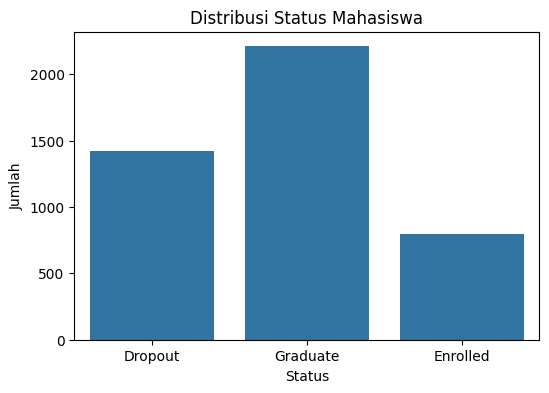

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(x='Status', data=df)
plt.title('Distribusi Status Mahasiswa')
plt.xlabel('Status')
plt.ylabel('Jumlah')
plt.show()

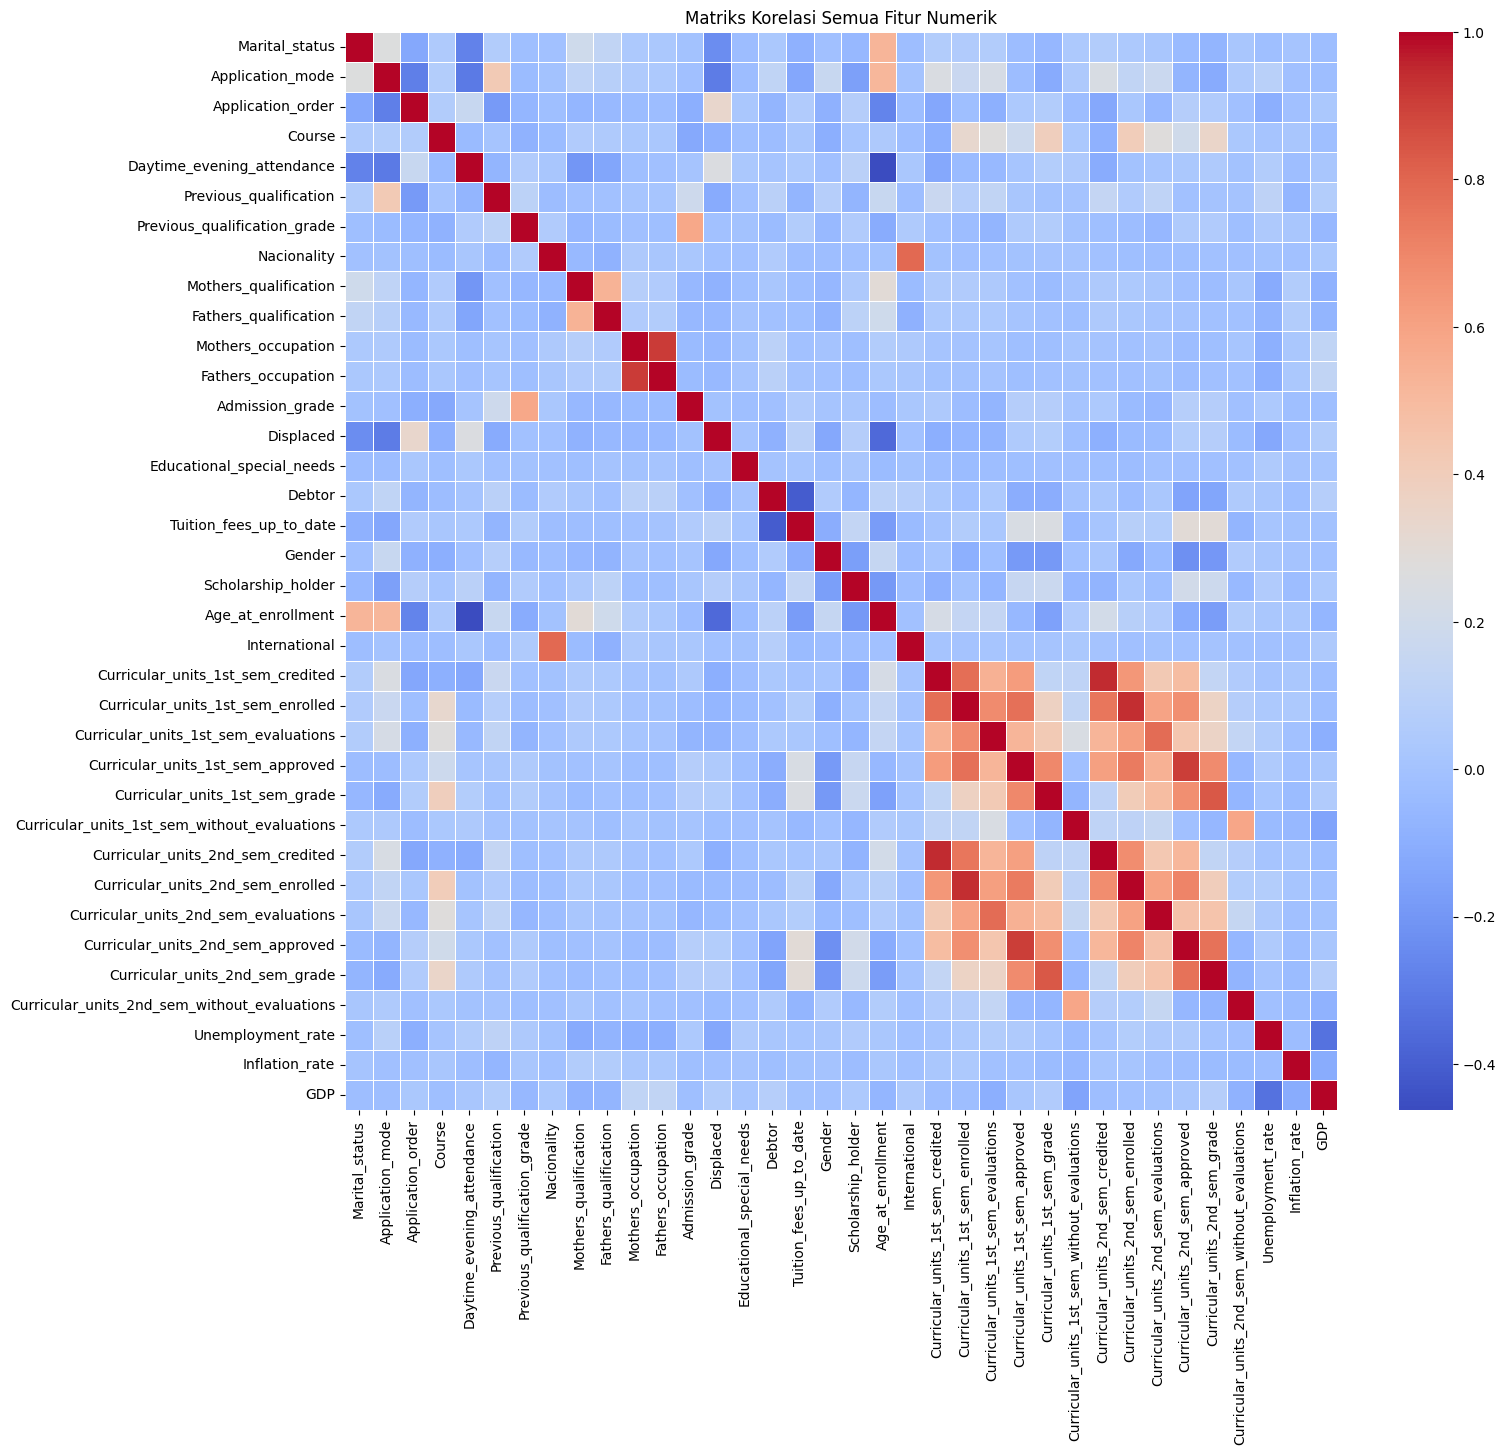

In [11]:
# cek korelasi antar fitur numerik
numeric_cols = df.select_dtypes(include=['int64','float64']).columns

# Hitung korelasi
corr_all = df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(16,14))
sns.heatmap(
    corr_all, 
    annot=False,     
    cmap='coolwarm', 
    linewidths=0.5
)
plt.title('Matriks Korelasi Semua Fitur Numerik')
plt.show()

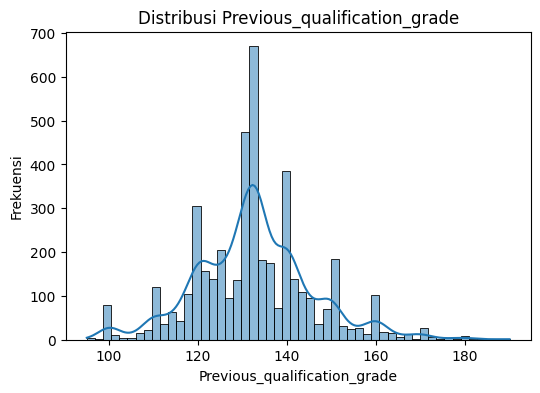

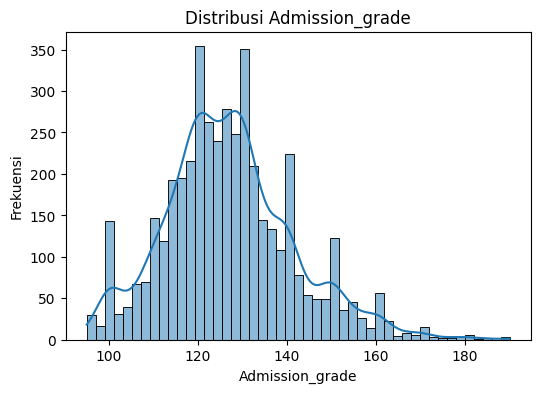

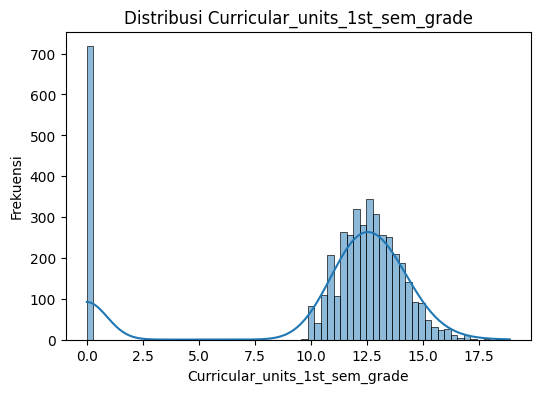

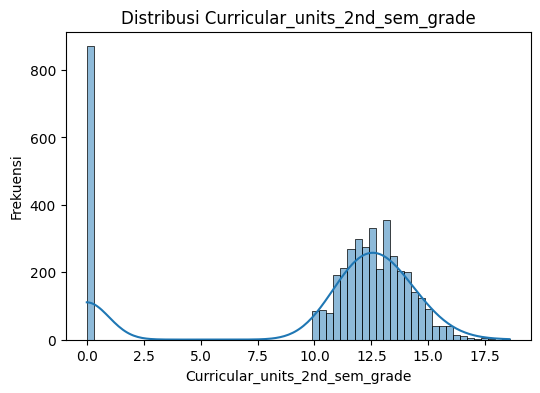

In [12]:
num_features = [
    'Previous_qualification_grade',
    'Admission_grade',
    'Curricular_units_1st_sem_grade',
    'Curricular_units_2nd_sem_grade'
]

for col in num_features:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribusi {col}')
    plt.xlabel(col)
    plt.ylabel('Frekuensi')
    plt.show()

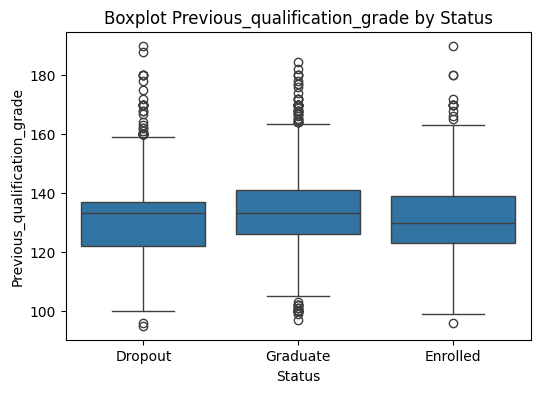

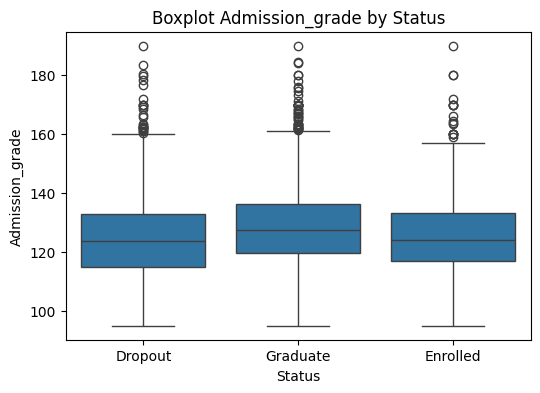

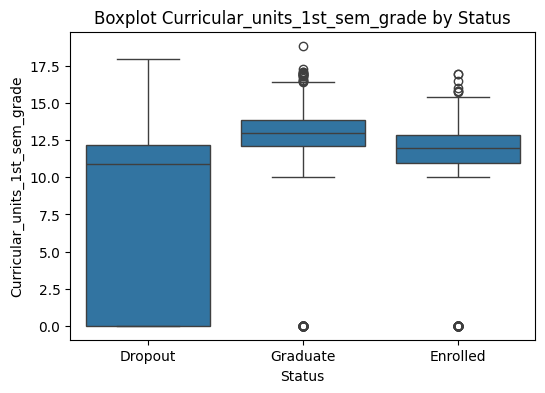

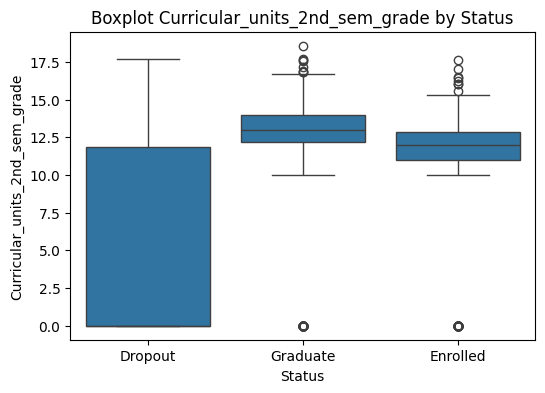

In [13]:
# Cek outlier pada fitur penting
num_feats = ['Previous_qualification_grade','Admission_grade',
             'Curricular_units_1st_sem_grade','Curricular_units_2nd_sem_grade']
for col in num_feats:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Status', y=col, data=df)
    plt.title(f'Boxplot {col} by Status')
    plt.show()

## Data Preparation / Preprocessing

In [14]:
# Encode target
df = df[df['Status'].isin(['Dropout','Graduate'])].copy()
df['Status_enc'] = df['Status'].map({'Dropout': 0, 'Graduate': 1})

# Cek hasil encoding
df[['Status', 'Status_enc']].head()

,Status,Status_enc
0,Dropout,0
1,Graduate,1
2,Dropout,0
3,Graduate,1
4,Graduate,1


In [15]:
# Split dataset
X = df.drop(columns=['Status','Status_enc'])
y = df['Status_enc']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)
print("Train set:", X_train.shape, "| Test set:", X_test.shape)

Train set: (2904, 36) | Test set: (726, 36)


In [16]:
# Scaling dan buang outlier
for col in X_train.columns:
    lower = X_train[col].quantile(0.01)
    upper = X_train[col].quantile(0.99)
    X_train[col] = X_train[col].clip(lower, upper)
    X_test[col]  = X_test[col].clip(lower, upper)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    index=X_train.index,
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    index=X_test.index,
    columns=X_test.columns
)

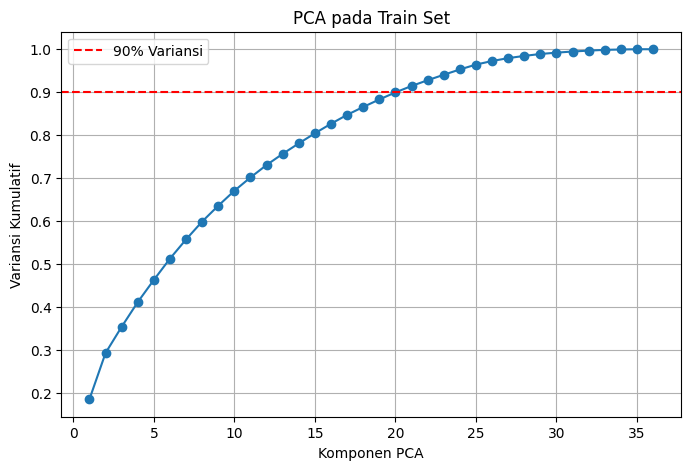

In [17]:
# Melakukan PCA analysis
pca = PCA()
pca.fit(X_train_scaled)

# Plot variansi kumulatif
cum_var = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.90, color='r', linestyle='--', label='90% Variansi')
plt.xlabel('Komponen PCA')
plt.ylabel('Variansi Kumulatif')
plt.title('PCA pada Train Set')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Seleksi fitur
loadings = pd.DataFrame(
    pca.components_.T,
    index=X_train_scaled.columns,
    columns=[f'PC{i+1}' for i in range(len(X_train_scaled.columns))]
)
low_feats = loadings[
    (loadings['PC1'].abs() < 0.1) &
    (loadings['PC2'].abs() < 0.1)
].index.tolist()
print("Fitur yang akan di drop:", low_feats)

# Cek fitur yang akan di drop
X_train_final = X_train_scaled.drop(columns=low_feats)
X_test_final  = X_test_scaled.drop(columns=low_feats)
print("Jumlah fitur setelah seleksi:", X_train_final.shape[1])

Fitur yang akan di drop: ['Previous_qualification_grade', 'Nacionality', 'Mothers_occupation', 'Fathers_occupation', 'Admission_grade', 'Educational_special_needs', 'International', 'Unemployment_rate', 'Inflation_rate', 'GDP']
Jumlah fitur setelah seleksi: 26


In [20]:
loading_scores = loadings[['PC1','PC2']].abs().sum(axis=1)

# Menggunakan top 20 fitur
top20 = loading_scores.sort_values(ascending=False).head(20).index.tolist()
print("20 Fitur Teratas berdasarkan PCA loadings:")
print(top20)

X_train_20 = X_train_final[top20].copy()
X_test_20  = X_test_final[top20].copy()
print("\nShape setelah subset:")
print("X_train_20:", X_train_20.shape)
print("X_test_20 :", X_test_20.shape)

20 Fitur Teratas berdasarkan PCA loadings:
['Curricular_units_2nd_sem_approved', 'Curricular_units_2nd_sem_grade', 'Curricular_units_1st_sem_grade', 'Curricular_units_1st_sem_credited', 'Curricular_units_1st_sem_approved', 'Curricular_units_2nd_sem_credited', 'Curricular_units_1st_sem_enrolled', 'Curricular_units_1st_sem_evaluations', 'Age_at_enrollment', 'Application_mode', 'Curricular_units_2nd_sem_enrolled', 'Curricular_units_2nd_sem_evaluations', 'Tuition_fees_up_to_date', 'Marital_status', 'Displaced', 'Daytime_evening_attendance', 'Application_order', 'Gender', 'Previous_qualification', 'Scholarship_holder']

Shape setelah subset:
X_train_20: (2904, 20)
X_test_20 : (726, 20)


## Modeling

In [24]:
models = {
    'LogisticRegression': (
        LogisticRegression(random_state=42, solver='liblinear', max_iter=1000),
        {'penalty': ['l1','l2'], 'C': [0.01,0.1,1]}
    ),
    'RandomForest': (
        RandomForestClassifier(random_state=42),
        {'n_estimators': [100,200],
         'max_features': ['sqrt','log2'],
         'max_depth': [None,10],
         'criterion': ['gini','entropy']}
    ),
    'GradientBoosting': (
        GradientBoostingClassifier(random_state=42),
        {'n_estimators': [200,300],
         'learning_rate': [0.01,0.1],
         'max_depth': [5,8],
         'subsample': [0.8,1.0],
         'max_features': ['sqrt','log2']}
    )
}

best_score = -1
best_model = None
best_name = None

for name, (est, grid) in models.items():
    gs = GridSearchCV(est, grid, cv=5, scoring='roc_auc', n_jobs=-1)
    gs.fit(X_train_20, y_train)
    print(f"{name:17s} → CV ROC-AUC = {gs.best_score_:.3f}, params={gs.best_params_}")
    if gs.best_score_ > best_score:
        best_score, best_model, best_name = gs.best_score_, gs.best_estimator_, name

print(f"\nBest model: {best_name} (CV ROC-AUC={best_score:.3f})")

LogisticRegression → CV ROC-AUC = 0.950, params={'C': 1, 'penalty': 'l2'}
RandomForest      → CV ROC-AUC = 0.946, params={'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
GradientBoosting  → CV ROC-AUC = 0.947, params={'learning_rate': 0.01, 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 300, 'subsample': 0.8}

Best model: LogisticRegression (CV ROC-AUC=0.950)


## Evaluation

In [29]:
y_prob = best_model.predict_proba(X_test_20)[:,1]
y_pred = best_model.predict(X_test_20)

print("\nTest ROC-AUC:", f"{roc_auc_score(y_test, y_prob):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Dropout','Graduate']))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Test ROC-AUC: 0.948

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.94      0.85      0.89       284
    Graduate       0.91      0.96      0.93       442

    accuracy                           0.92       726
   macro avg       0.92      0.90      0.91       726
weighted avg       0.92      0.92      0.92       726

Confusion Matrix:
 [[240  44]
 [ 16 426]]


In [37]:
# simpan model
if os.path.exists('model'):
    shutil.rmtree('model')
os.makedirs('model', exist_ok=True)

joblib.dump(best_model, 'model/best_model.joblib')
print(f"\nBest model tersimpan")

scaler_20 = StandardScaler()
scaler_20.fit(X_train_20)  

pipe20 = Pipeline([
    ('scaler', scaler_20),
    ('model', best_model)
])


joblib.dump(pipe20, "model/dropout_predict_pipeline.joblib")
print("Pipeline berhasil tersimpan")



Best model tersimpan
Pipeline berhasil tersimpan
